<a href="https://colab.research.google.com/github/nepia-infinity/Get-Access-Data-With-Gemini/blob/main/Gemini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **緯度経度・最寄り駅などを出力させる**

In [ ]:
# 初回のみ実行が必要
!pip install google-generativeai

In [4]:
# GeminiのAPI keyを読み込む
import google.generativeai as genai
from google.colab import userdata

# 汎用的なライブラリを読み込む
import json,re
import pandas as pd
import urllib.parse

# Google Colabの認証を付与する
from google.colab import auth
auth.authenticate_user()

# Google Spreadsheetとの連携
import gspread
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)



def call_gemini_api(name: str) -> dict:
  """
  指定された施設名のアクセスに関する情報を Gemini API 経由で取得し、JSON 形式で返します。

  Args:
      name (str): 施設名の名前　Spreadsheetのname_listシートに記述

  Returns:
      dict: JSON データ

  Note:
    * Gemini API の出力（文字列）から不要な文字列を削除し、JSON 形式に変換します。
    * gemini-1.5-flashでは、緯度経度は正しくないデータが出力されます
    * 施設名に東京（ex. 東京ジョイポリス、東京スカイツリーなど）が付く場合、
    * 名前から推測される駅名などを返すケースが多く、ハルシネーションに注意が必要です。

  """

  # JSONのサンプル
  json_sample = {
    "name": "具体的な施設名",
    "latitude": 35.658581,
    "longitude": 139.745433,
    "nearest_station": "赤羽橋駅",
    "access": {
      "car": [
        {
          "line": "首都高速道路都心環状線",
          "highway_exit": "芝公園出口",
          "minutes": "車で3分"
        },
      ],
      "train": [
        {
          "line": "都営大江戸線",
          "station_name": "赤羽橋駅",
          "ticket_gate": "南改札口",
          "minutes": "徒歩5分"
        },
        {
          "line": "都営三田線",
          "station_name": "御成門駅",
          "ticket_gate": "A3出口",
          "minutes": "徒歩5分"
        }
      ],
      "bus": [
        {
          "line": "都営バス",
          "bus_stop": "東京タワー前",
          "minutes": "徒歩2分"
        }
      ]
    }
  }

  # print(f"API Key: {userdata.get('GEMINI_API_KEY')}")

  prompt = f'あなたは週末のお出かけスポット特集の記事原稿を手掛けるライターのプロです。{name}に対して以下の情報をJSONで返してください。緯度、経度、地下鉄を含むすべての路線(電車)、高速道路の出口（※複数ある場合はすべて列挙してください。）、徒歩、車などアクセスに関する情報。\nJSONの構造については下記を参考にしてください\n\n{json_sample}\nJSONのKeyはすべてダブルクォーテーションで囲んでください'
  print(f'\n{prompt}')

  # Geminiの出力結果を取得する
  genai.configure(api_key=userdata.get("GEMINI_API_KEY"))
  model = genai.GenerativeModel(model_name="gemini-1.5-flash")
  response = model.generate_content(prompt)
  output   = response.text
  print(f'\nGeminiの出力結果 修正前（型:{type(output)}）')
  print(f'{output}\n')

  # 出力結果に含まれている余計な文字列を削除
  output = re.sub(r'^```json\n', '', output)
  output = re.sub(r'```$', '', output)

  # テキスト内容を出力
  print(f'Geminiの出力結果 修正後（型:{type(output)}）')
  print(f'{output}\n')
  print('トークン数を出力')
  print(response.usage_metadata)

  try:
      data = json.loads(output)
  except json.JSONDecodeError as e:
      print(f"JSON Decode Error: {e}")
      # エラーが発生した場合、出力内容を確認してデバッグ
      print(f"Output: {output}")
      data = None  # または、適切なエラー値を返す
  except Exception as e:
      print(f"An unexpected error occurred: {e}")
      data = None

  return data



def convert_data_to_list(data):
  """
  Gemini API から取得した JSON データを、アクセス情報ごとにリストに変換します。

  Args:
      data: 場所情報を含む JSON データ

  Returns:
      アクセス情報ごとにリスト化されたデータ

  """

  access_data = []

  # Google MapのURLを生成
  encoded_place_name = urllib.parse.quote(name)
  google_maps_url = f"https://www.google.com/maps/search/?api=1&query={encoded_place_name}"

  # Geminiの応答結果から電車、バス、車のアクセスのみを取得し、配列に追加
  for access_type in ["train", "bus", "car"]:
    if access_type not in data["access"]:
      continue  # 電車、バス、車以外の交通手段の場合はスキップ

    for item in data["access"][access_type]:
      row = [data["name"], data["latitude"], data["longitude"], data["nearest_station"]]
      if access_type == "train":
        row.extend(["電車", item["line"], item["station_name"], item.get("minutes", ""), google_maps_url])

      elif access_type == "bus":
        row.extend(["バス", item["line"], item["bus_stop"], item.get("minutes", ""), google_maps_url])

      elif access_type == "car":
        row.extend(["車", item.get("line", ""), item["highway_exit"], item.get("minutes", ""), google_maps_url])

      access_data.append(row)

  print(access_data)
  return access_data



def get_sheet_values(sheet_url: str, sheet_name: str) -> list[list]:
  """
  指定されたシートの値をすべて取得します。

  Args:
    sheet_url (str): 取得したいスプレッドシートのURL
    sheet_name (str): 値を取得したいシートの名前

  Returns:
    list[list]: シート内のすべての値を二次元リストで返します。

  """

  spreadsheet = gc.open_by_url(sheet_url)
  sheet = spreadsheet.worksheet(sheet_name)
  print(f'\nファイル名：{spreadsheet.title}')
  print(f'情報の取得元シート：{sheet_name}\n')

  values = sheet.get_all_values()
  return values



def convert_values_to_list(values: list[list[str]], column_index: int) ->list[str]:
  """
  2次元リストから指定された列の値を抽出し、1次元リストに変換します。

  Args:
    values: 値を含む 2次元リスト
    column_index: 抽出したい列のインデックス (0 始まり)

  Returns:
    指定された列の値を含む 1次元リスト

  """

  df = pd.DataFrame(values)

  # 1列目の値をリストとして取得
  target_column_values = df.iloc[:, column_index].tolist()

  print(target_column_values)
  return target_column_values


def update_sheet(sheet_url: str, sheet_name: str, target_row: int, access_data: list[list]) -> None:
  """
  指定されたスプレッドシートの特定のシートに、アクセス情報を書き込みます。

  Args:
      sheet_url (str): 更新したいスプレッドシートのURL
      sheet_name (str): 書き込み先のシートの名前
      target_row (int): 書き込み開始行番号 (1始まり)
      access_data (list[list]): 書き込むアクセス情報を含む2次元リスト

  Returns:
      None

  """

  spreadsheet = gc.open_by_url(sheet_url)
  sheet = spreadsheet.worksheet(sheet_name)
  print(f'ファイル名：{spreadsheet.title}')
  print(f'転記予定のシート：{sheet_name}')

  # 新しい値を貼り付け
  cell_range = f"A{target_row}:Z{target_row + len(access_data) - 1}"
  print(cell_range)

  sheet.update(access_data, cell_range)
  print("転記完了")
  print(f"{sheet_url}")

  return None



# ここから一連の処理を開始
ref_sheet_url = "https://docs.google.com/spreadsheets/d/1GgazOc_oCEfbLaIj254TpGJrKBNxQc_0IpLC25L78rs/edit?gid=1459905465#gid=1459905465"
ref_sheet_name = "name_list"
ref_sheet_values = get_sheet_values(ref_sheet_url, ref_sheet_name)

# 施設名のリストを取得
list_item = convert_values_to_list(ref_sheet_values, 0)

# URLから転記先Spreadsheetを開く
sheet_url = "https://docs.google.com/spreadsheets/d/1GgazOc_oCEfbLaIj254TpGJrKBNxQc_0IpLC25L78rs/edit?gid=0#gid=0"
sheet_name = "gemini_response"

# 転記するために最終行判定のために値を取得する
original = get_sheet_values(sheet_url, sheet_name)

# 最終行を取得
target_row = len(original) + 1
print(f"転記対象行: {target_row}行目")

# 施設名のリストをループ処理
for name in list_item:
    data = call_gemini_api(name)
    access_data = convert_data_to_list(data)

    # 指定したシートにGeminiの出力結果を転記する
    update_sheet(sheet_url, sheet_name, target_row, access_data)

    # 最終行を更新
    target_row += len(access_data)

    # 必要に応じて、次の施設名の処理前に少し待つ
    # time.sleep(1)  # 例: 1秒待つ






ファイル名：Gemini書き出しテスト
情報の取得元シート：name_list

['すみだ水族館', '東京ジョイポリス', '江の島水族館', '西武遊園地', '東京スカイツリー', '東京ディズニーランド', '鴨川シーワールド', 'サンシャイン水族館', '上野動物園', '国立科学博物館', '東京ドイツ村']

ファイル名：Gemini書き出しテスト
情報の取得元シート：gemini_response

転記対象行: 2


あなたは週末のお出かけスポット特集の記事原稿を手掛けるライターのプロです。すみだ水族館に対して以下の情報をJSONで返してください。緯度、経度、地下鉄を含むすべての路線(電車)、高速道路の出口（※複数ある場合はすべて列挙してください。）、徒歩、車などアクセスに関する情報。
JSONの構造については下記を参考にしてください

{'name': '具体的な施設名', 'latitude': 35.658581, 'longitude': 139.745433, 'nearest_station': '赤羽橋駅', 'access': {'car': [{'line': '首都高速道路都心環状線', 'highway_exit': '芝公園出口', 'minutes': '車で3分'}], 'train': [{'line': '都営大江戸線', 'station_name': '赤羽橋駅', 'ticket_gate': '南改札口', 'minutes': '徒歩5分'}, {'line': '都営三田線', 'station_name': '御成門駅', 'ticket_gate': 'A3出口', 'minutes': '徒歩5分'}], 'bus': [{'line': '都営バス', 'bus_stop': '東京タワー前', 'minutes': '徒歩2分'}]}}
JSONのKeyはすべてダブルクォーテーションで囲んでください

Geminiの出力結果 修正前（型:<class 'str'>）
```json
{"name": "すみだ水族館", "latitude": 35.708758, "longitude": 139.809228, "nearest_station": "東京スカイツリー駅", "acce

# **画像を読み込んで生成AIに説明文を書かせる**

In [ ]:
import google.generativeai as genai
import PIL.Image
import os
from google.colab import drive, userdata

# Google Driveをマウント
drive.mount('/content/drive')

# 画像をgeminiに送り、何の画像かを判別してもらう
genai.configure(api_key=userdata.get("GEMINI_API_KEY"))
file_path = '/content/drive/MyDrive/Python_Test_Image/bol.png'
img = PIL.Image.open(file_path)

model = genai.GenerativeModel(model_name="gemini-1.5-flash")
response = model.generate_content(["あなたは週末のお出かけスポットやアクティビティ施設を特集するライターのプロです。読者が遊びに行きたいと思うように写真の魅力を200字で語ってみてください", img])
print(response.text)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
カラフルなホールドがびっしり並んだボルダリングウォール。初心者から上級者まで楽しめる、ワクワクする空間が広がっています。真剣な表情で壁に挑む姿は、見ているだけでも気持ちがアガります。汗を流して、心も体もリフレッシュしませんか？ 



# **Google Mapsのリダイレクト先に緯度経度が含まれているので取得できないかトライしてみた**

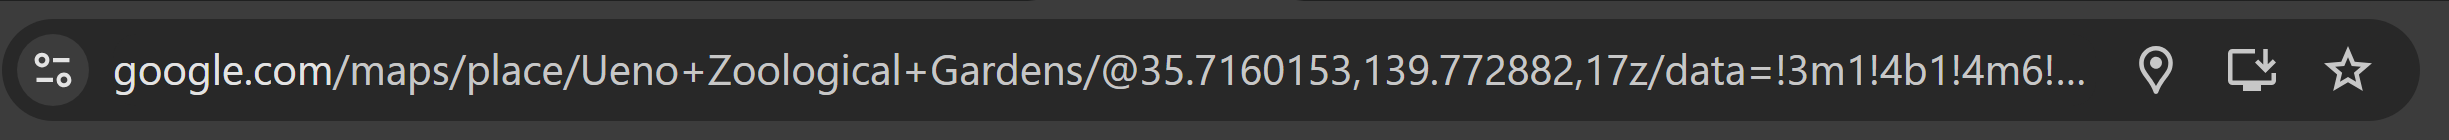

> 35.7160153,139.772882

正確な緯度経度取得に拘るのであれば、Google Map APIの利用が必須

In [ ]:
'''
Chat GPT
リダイレクト先のURLがconsent.google.comになっているため、緯度経度の情報が含まれていないようです。
Googleの同意ページを通過する必要があるため、直接的に緯度経度を取得するのが難しい状況です。
'''


import requests
from urllib.parse import urlparse, parse_qs

# Google Mapsの検索URL
target_url = "https://www.google.com/maps/search/?api=1&query=Tokyo+Tower"

# リクエストを送信してリダイレクト先のURLを取得できないかを試してみた
response = requests.get(target_url)
redirected_url = response.url
# print(response) # 200
# print(redirected_url)

# URLを解析してクエリパラメータを取得
parsed_url = urlparse(redirected_url)
query_params = parse_qs(parsed_url.query)
print(parsed_url)
print(query_params)

# 緯度と経度を抽出
# latitude = query_params.get('query')[0].split(',')[0]
# longitude = query_params.get('query')[0].split(',')[1]

# print(f"Latitude: {latitude}, Longitude: {longitude}")


ParseResult(scheme='https', netloc='consent.google.com', path='/ml', params='', query='continue=https://www.google.com/maps/search/?api%3D1%26query%3DTokyo%2BTower&gl=NL&m=0&pc=m&uxe=eomtm&cm=2&hl=nl&src=1', fragment='')
{'continue': ['https://www.google.com/maps/search/?api=1&query=Tokyo+Tower'], 'gl': ['NL'], 'm': ['0'], 'pc': ['m'], 'uxe': ['eomtm'], 'cm': ['2'], 'hl': ['nl'], 'src': ['1']}
